## IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import warnings
from datetime import datetime

# Sklearn utilities
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## LOAD ENGINEERED FEATURES

In [3]:
# Load scaled features
df = pd.read_csv('../dataset/processed/engineered_features_scaled.csv')

# Load metadata
with open('../dataset/processed/feature_metadata.json', 'r') as f:
    metadata = json.load(f)

print("=" * 60)
print("DATA OVERVIEW")
print("=" * 60)
print(f"\nTotal samples: {len(df)}")
print(f"Number of features: {len(metadata['feature_names'])}")
print(f"\nFeatures: {metadata['feature_names']}")
print(f"\nTarget distribution:")
print(df['score'].describe())

DATA OVERVIEW

Total samples: 42650
Number of features: 16

Features: ['skill_jaccard', 'skill_coverage', 'skill_precision', 'skill_overlap_count', 'job_skills_count', 'cv_skills_count', 'experience_gap', 'experience_ratio', 'experience_match', 'job_experience_required', 'cv_experience_years', 'education_gap', 'education_match', 'job_education_level', 'cv_education_level', 'seniority_match_score']

Target distribution:
count    42650.000000
mean        33.398676
std         14.320120
min          2.010000
25%         23.450000
50%         30.360000
75%         41.250000
max        100.000000
Name: score, dtype: float64


## PREPARE DATA SPLITS

In [4]:
feature_cols = metadata['feature_names']
X = df[feature_cols]
y = df['score']

# Split theo tỉ lệ 70/15/15
print("Splitting data into train/validation/test sets...")
print("Strategy: 70% train, 15% validation, 15% test\n")

# Vì công cụ train_test_split chỉ chia được 1 tập thành 2 tập => ta sẽ phải chia 2 lần

# Lần split đầu: 70% tập train, 30% tập temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

# Lần split 2nd: split tập temp thành tập validation và tập test (50-50)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)

print(f"Training set:   {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test set:       {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")

print("\nTarget distribution across splits:")
print(f"Train:      mean={y_train.mean():.2f}, std={y_train.std():.2f}")
print(f"Validation: mean={y_val.mean():.2f}, std={y_val.std():.2f}")
print(f"Test:       mean={y_test.mean():.2f}, std={y_test.std():.2f}")

Splitting data into train/validation/test sets...
Strategy: 70% train, 15% validation, 15% test

Training set:   29855 samples (70.0%)
Validation set: 6397 samples (15.0%)
Test set:       6398 samples (15.0%)

Target distribution across splits:
Train:      mean=33.40, std=14.36
Validation: mean=33.59, std=14.26
Test:       mean=33.22, std=14.19


## HELPER FUNCTION

In [5]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\nTraining {model_name}...")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Evaluate
    train_metrics = {
        'mse': mean_squared_error(y_train, y_train_pred),
        'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'mae': mean_absolute_error(y_train, y_train_pred),
        'r2': r2_score(y_train, y_train_pred)
    }

    val_metrics = {
        'mse': mean_squared_error(y_val, y_val_pred),
        'rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'mae': mean_absolute_error(y_val, y_val_pred),
        'r2': r2_score(y_val, y_val_pred)
    }

    print(f"  Train - RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}, R²: {train_metrics['r2']:.4f}")
    print(f"  Val   - RMSE: {val_metrics['rmse']:.4f}, MAE: {val_metrics['mae']:.4f}, R²: {val_metrics['r2']:.4f}")

    return model, train_metrics, val_metrics


def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.3, s=10)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
             'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Score')
    plt.ylabel('Predicted Score')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Residuals scatter
    axes[0].scatter(y_pred, residuals, alpha=0.3, s=10)
    axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Predicted Score')
    axes[0].set_ylabel('Residuals')
    axes[0].set_title(f'{title} - Residual Plot')
    axes[0].grid(True, alpha=0.3)

    # Residuals histogram
    axes[1].hist(residuals, bins=50, edgecolor='black')
    axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Residuals')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{title} - Residual Distribution')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## BASELINE MODELS

### 1. Linear Regression


Training Linear Regression...
  Train - RMSE: 4.3686, MAE: 3.3898, R²: 0.9075
  Val   - RMSE: 4.3517, MAE: 3.3737, R²: 0.9068


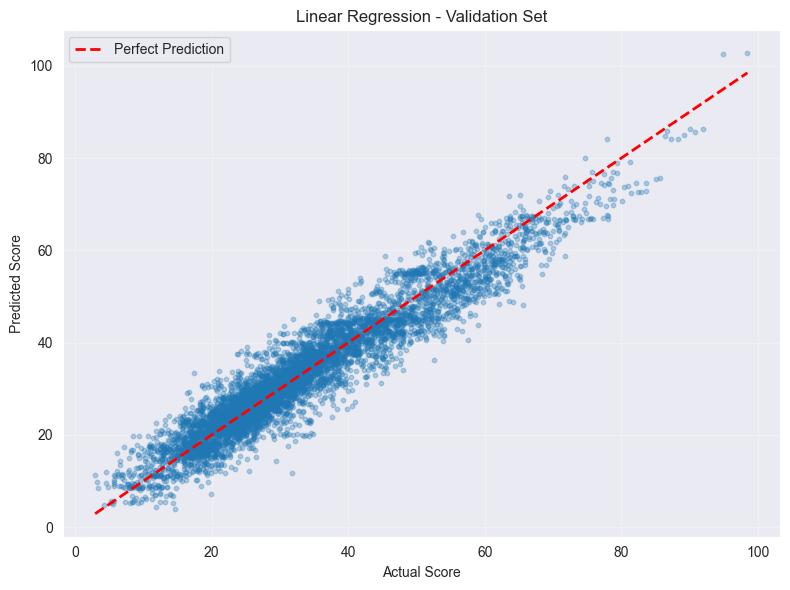

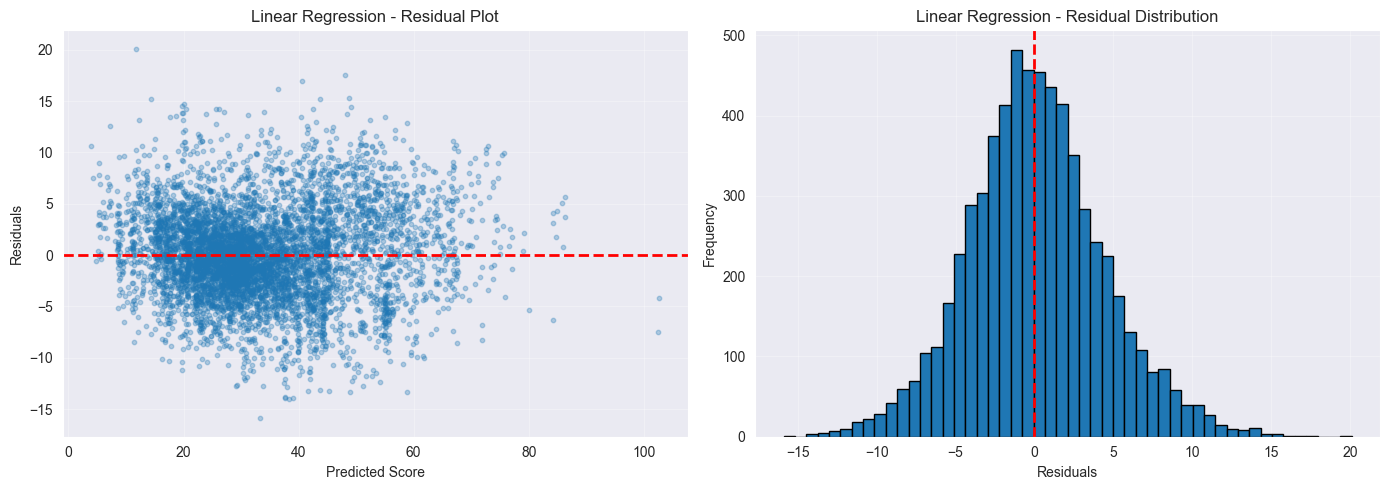

In [6]:

lr_model = LinearRegression()
lr_model, lr_train_metrics, lr_val_metrics = evaluate_model(
    lr_model, X_train, y_train, X_val, y_val, "Linear Regression"
)

# Trực quan hóa
y_val_pred = lr_model.predict(X_val)
plot_predictions(y_val, y_val_pred, "Linear Regression - Validation Set")
plot_residuals(y_val, y_val_pred, "Linear Regression")

### 2. Ridge Regression


Training Ridge Regression...
  Train - RMSE: 4.3686, MAE: 3.3898, R²: 0.9075
  Val   - RMSE: 4.3517, MAE: 3.3737, R²: 0.9068


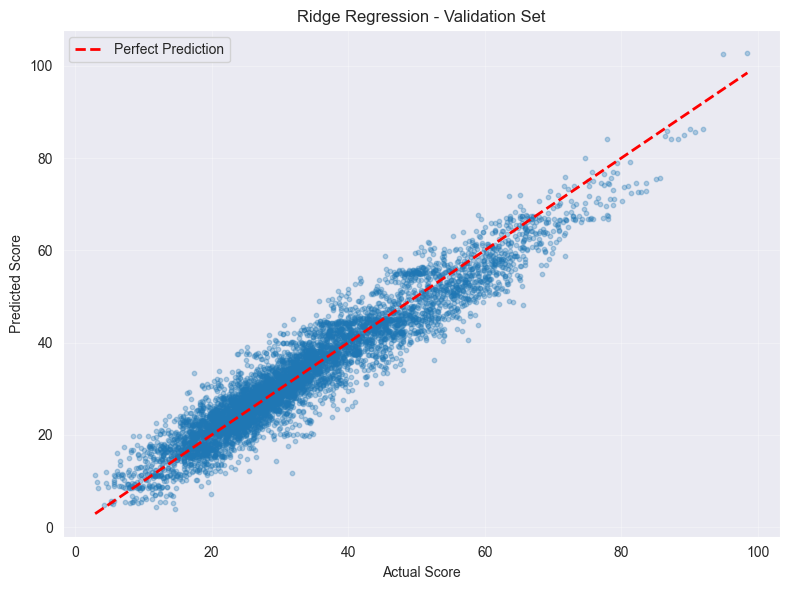

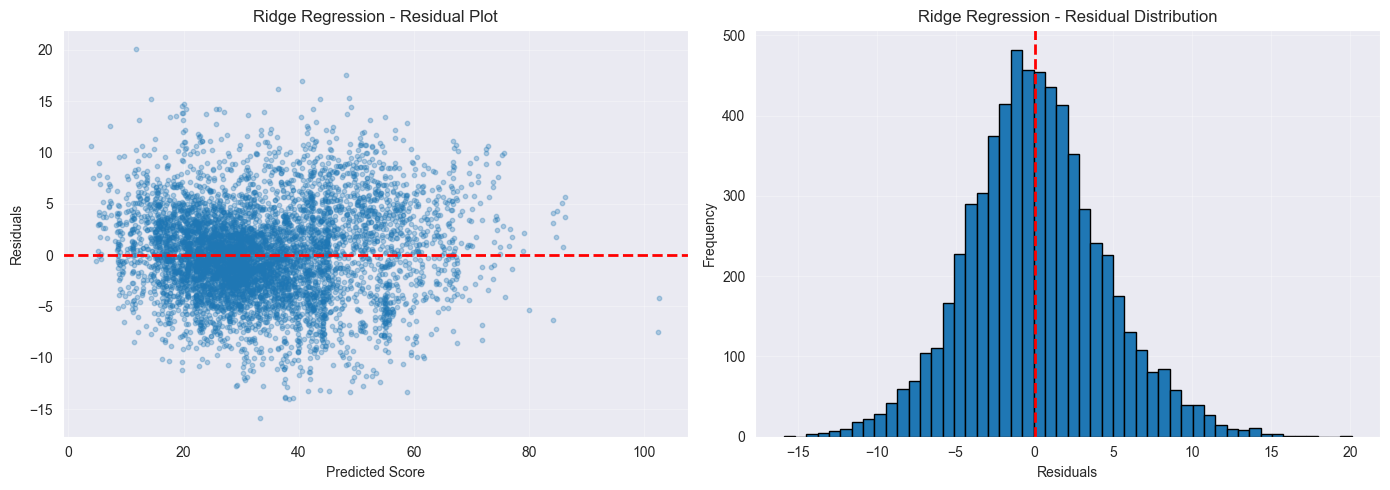

In [7]:
# Train
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model, ridge_train_metrics, ridge_val_metrics = evaluate_model(
    ridge_model, X_train, y_train, X_val, y_val, "Ridge Regression"
)

# Trực quan hóa
y_val_pred = ridge_model.predict(X_val)
plot_predictions(y_val, y_val_pred, "Ridge Regression - Validation Set")
plot_residuals(y_val, y_val_pred, "Ridge Regression")

### 3. Lasso Regression


Training Lasso Regression...
  Train - RMSE: 4.7882, MAE: 3.6900, R²: 0.8888
  Val   - RMSE: 4.8007, MAE: 3.6973, R²: 0.8866


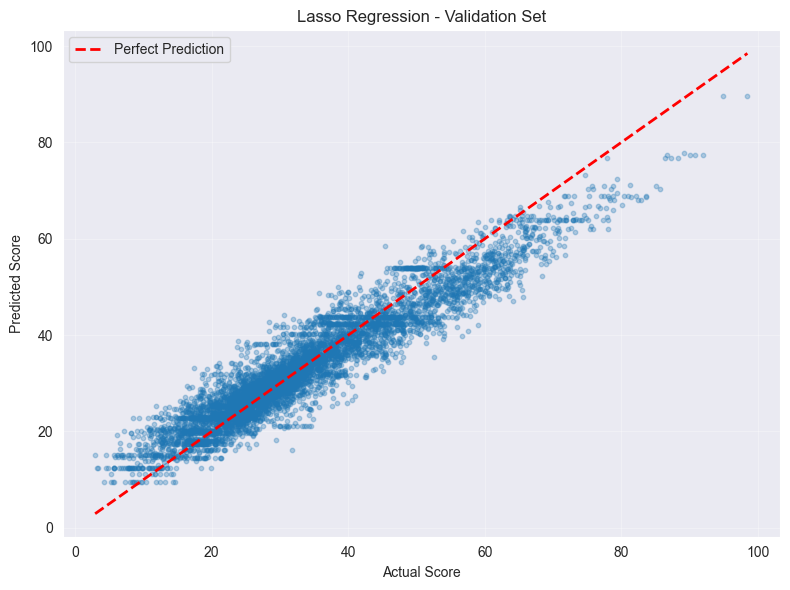

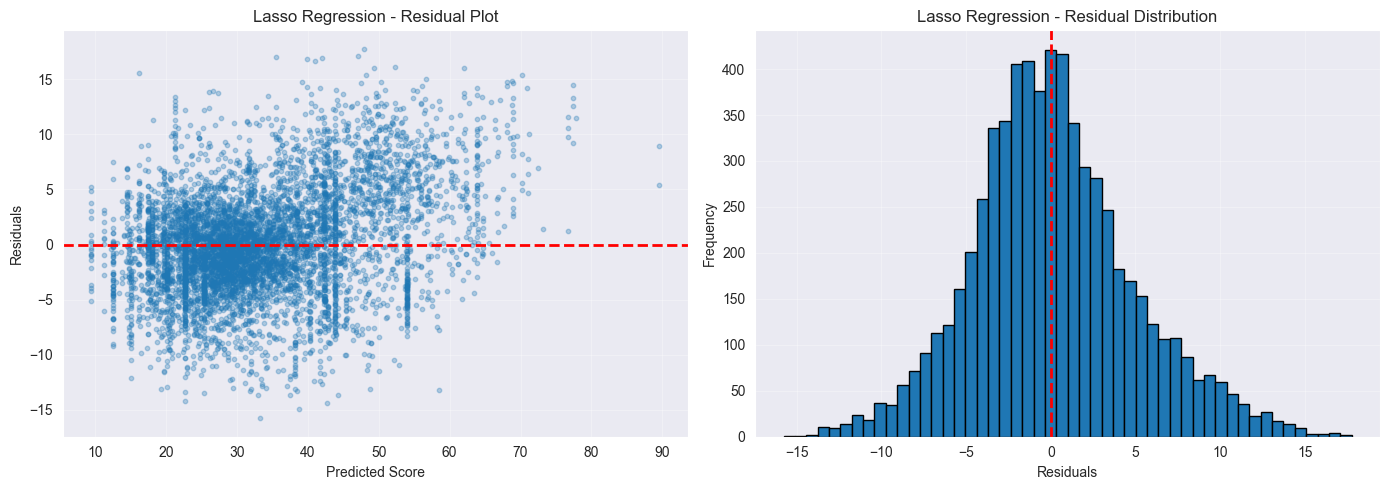

In [8]:
# Train
lasso_model = Lasso(alpha=1.0, random_state=42)
lasso_model, lasso_train_metrics, lasso_val_metrics = evaluate_model(
    lasso_model, X_train, y_train, X_val, y_val, "Lasso Regression"
)

# Trực quan hóa
y_val_pred = lasso_model.predict(X_val)
plot_predictions(y_val, y_val_pred, "Lasso Regression - Validation Set")
plot_residuals(y_val, y_val_pred, "Lasso Regression")

### 4. Decision Tree


Training Decision Tree...
  Train - RMSE: 2.3586, MAE: 1.8242, R²: 0.9730
  Val   - RMSE: 2.5994, MAE: 1.9812, R²: 0.9668


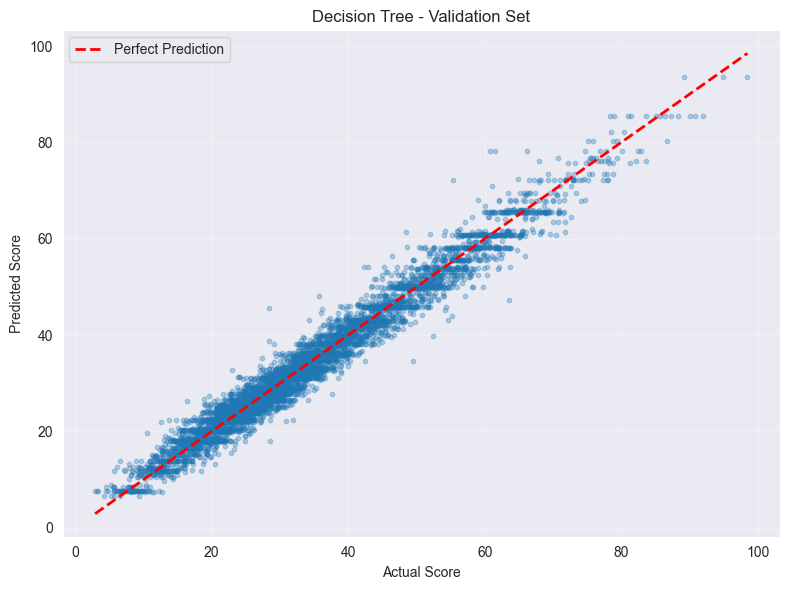

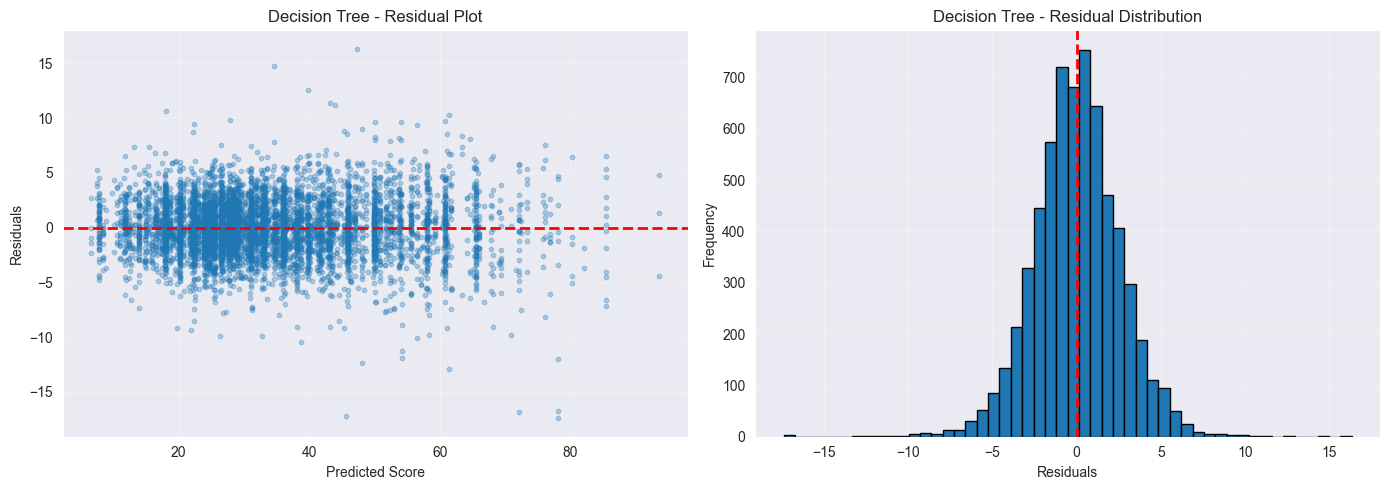

In [9]:
# Train
dt_model = DecisionTreeRegressor(max_depth=10, min_samples_split=20, random_state=42)
dt_model, dt_train_metrics, dt_val_metrics = evaluate_model(
    dt_model, X_train, y_train, X_val, y_val, "Decision Tree"
)

# Trực quan hóa
y_val_pred = dt_model.predict(X_val)
plot_predictions(y_val, y_val_pred, "Decision Tree - Validation Set")
plot_residuals(y_val, y_val_pred, "Decision Tree")

### 5. Random Forest


Training Random Forest...
  Train - RMSE: 1.9402, MAE: 1.5132, R²: 0.9817
  Val   - RMSE: 2.3427, MAE: 1.8287, R²: 0.9730


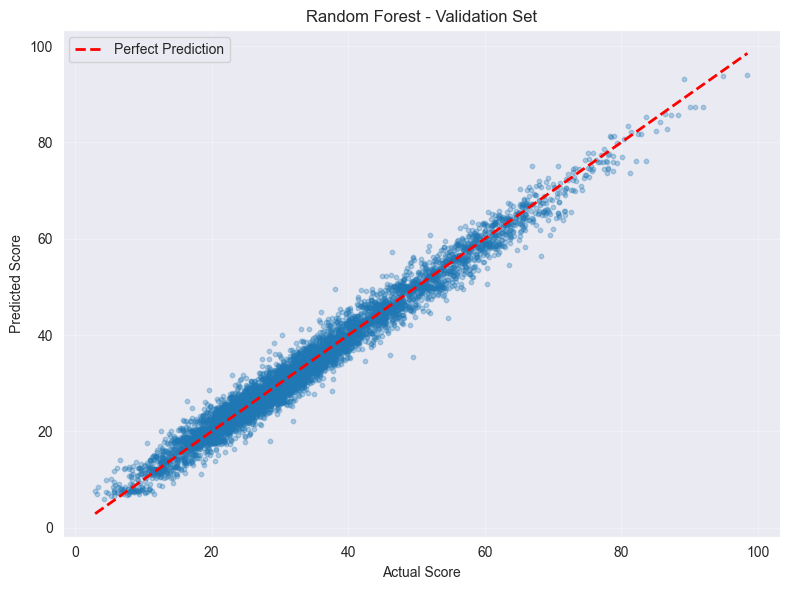

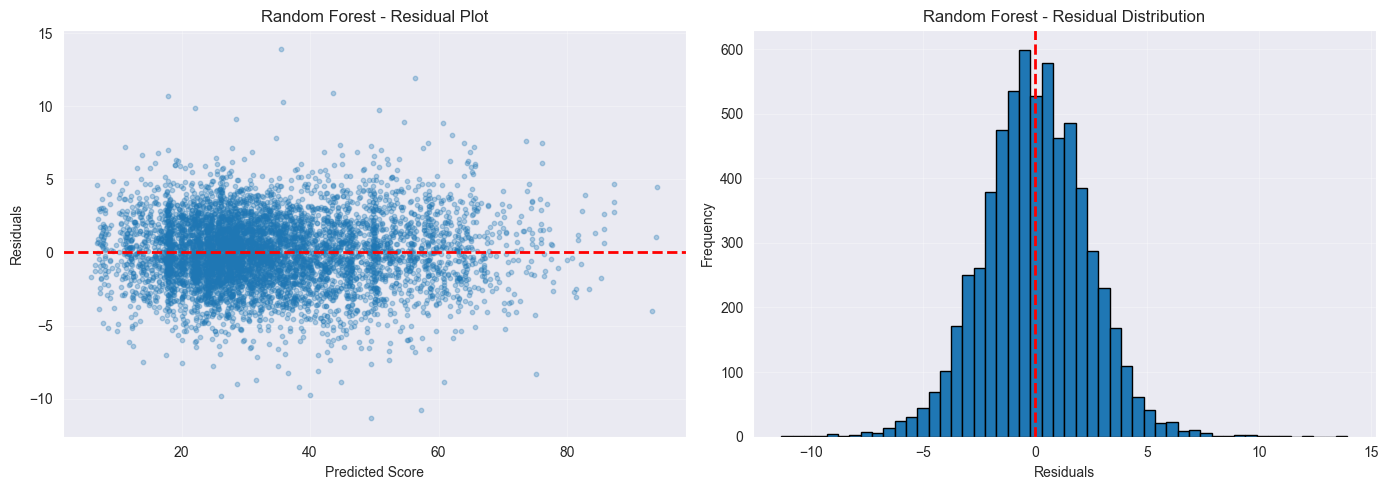

In [10]:
# Train
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)
rf_model, rf_train_metrics, rf_val_metrics = evaluate_model(
    rf_model, X_train, y_train, X_val, y_val, "Random Forest"
)

# Trực quan hóa
y_val_pred = rf_model.predict(X_val)
plot_predictions(y_val, y_val_pred, "Random Forest - Validation Set")
plot_residuals(y_val, y_val_pred, "Random Forest")

### 6. Gradient Boosting


Training Gradient Boosting...
  Train - RMSE: 2.1337, MAE: 1.6783, R²: 0.9779
  Val   - RMSE: 2.2084, MAE: 1.7357, R²: 0.9760


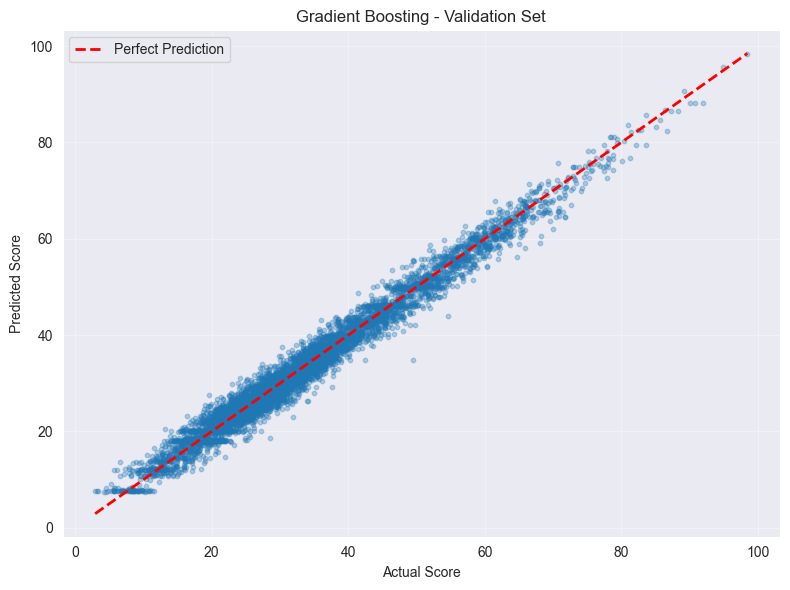

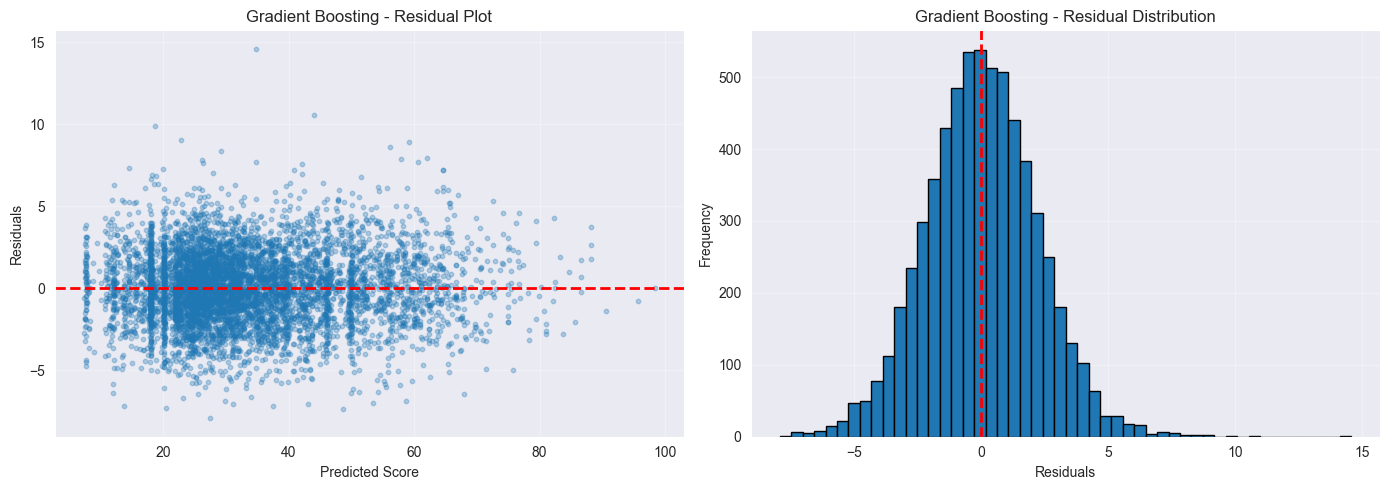

In [11]:
# Train
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    random_state=42
)
gb_model, gb_train_metrics, gb_val_metrics = evaluate_model(
    gb_model, X_train, y_train, X_val, y_val, "Gradient Boosting"
)

# Trực quan hóa
y_val_pred = gb_model.predict(X_val)
plot_predictions(y_val, y_val_pred, "Gradient Boosting - Validation Set")
plot_residuals(y_val, y_val_pred, "Gradient Boosting")

### 7. XGBoost


Training XGBoost...
  Train - RMSE: 2.0836, MAE: 1.6395, R²: 0.9789
  Val   - RMSE: 2.1977, MAE: 1.7331, R²: 0.9762


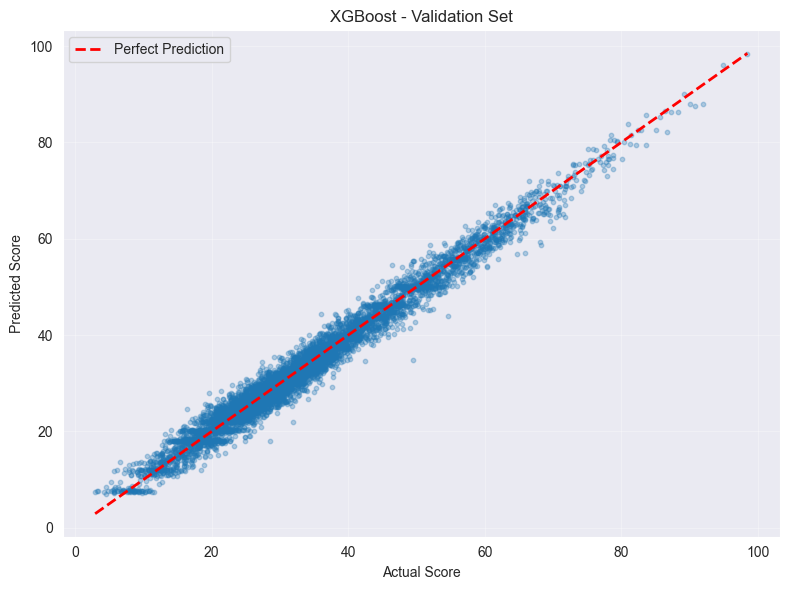

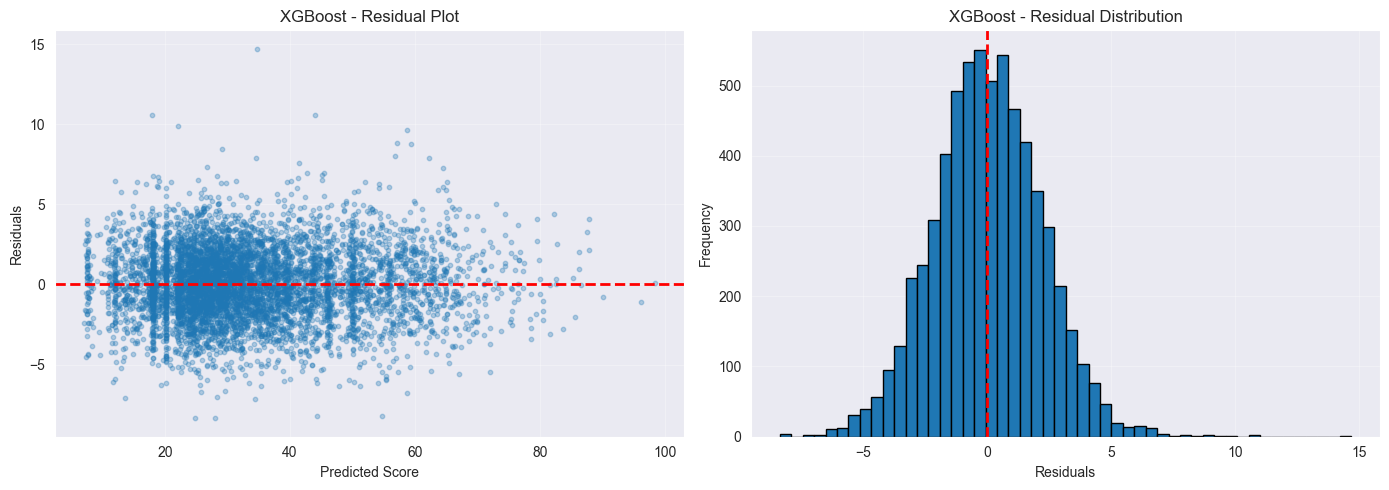

In [12]:
# Train
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model, xgb_train_metrics, xgb_val_metrics = evaluate_model(
    xgb_model, X_train, y_train, X_val, y_val, "XGBoost"
)

# Trực quan hóa
y_val_pred = xgb_model.predict(X_val)
plot_predictions(y_val, y_val_pred, "XGBoost - Validation Set")
plot_residuals(y_val, y_val_pred, "XGBoost")

### 8. LìghtGBM


Training LightGBM...
  Train - RMSE: 2.1595, MAE: 1.6929, R²: 0.9774
  Val   - RMSE: 2.2205, MAE: 1.7411, R²: 0.9757


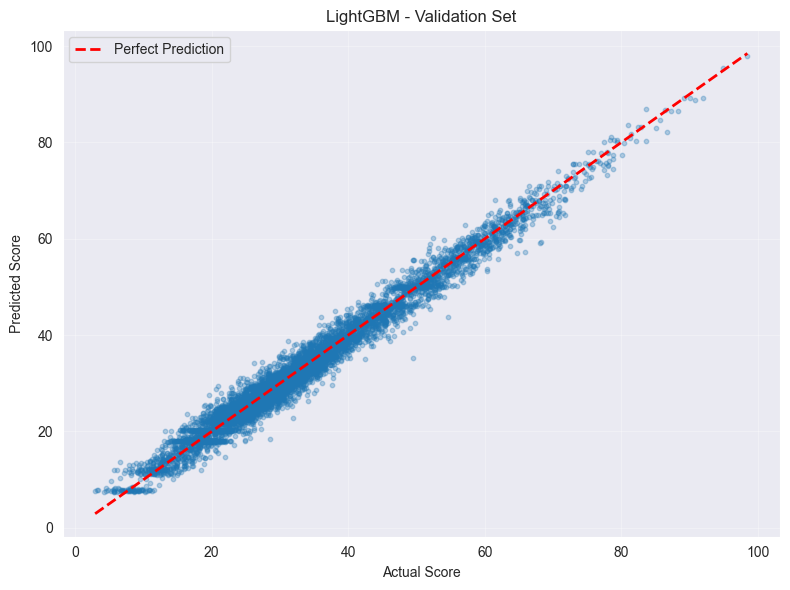

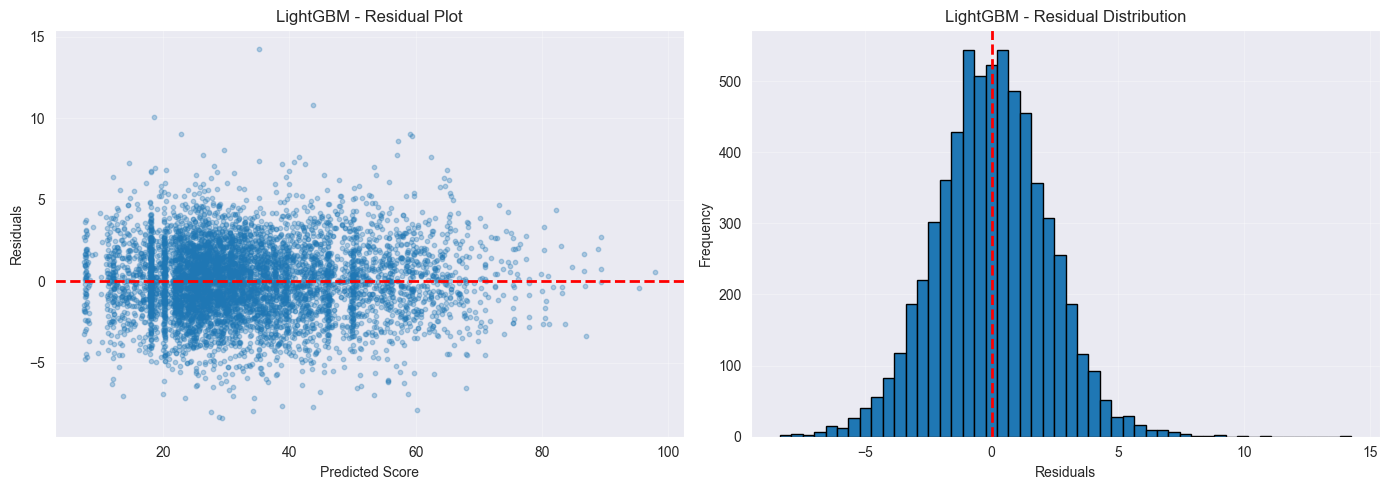

In [13]:
# Train
lgbm_model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgbm_model, lgbm_train_metrics, lgbm_val_metrics = evaluate_model(
    lgbm_model, X_train, y_train, X_val, y_val, "LightGBM"
)

# Trực quan hóa
y_val_pred = lgbm_model.predict(X_val)
plot_predictions(y_val, y_val_pred, "LightGBM - Validation Set")
plot_residuals(y_val, y_val_pred, "LightGBM")

## MODEL COMPARISON

### 1. Evaluation Metrics

In [14]:
results = {
    'Linear Regression': lr_val_metrics,
    'Ridge Regression': ridge_val_metrics,
    'Lasso Regression': lasso_val_metrics,
    'Decision Tree': dt_val_metrics,
    'Random Forest': rf_val_metrics,
    'Gradient Boosting': gb_val_metrics,
    'XGBoost': xgb_val_metrics,
    'LightGBM': lgbm_val_metrics
}

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('rmse')

print("=" * 60)
print("MODEL COMPARISON (Validation Set)")
print("=" * 60)
print(results_df.to_string())

MODEL COMPARISON (Validation Set)
                         mse      rmse       mae        r2
XGBoost             4.829954  2.197716  1.733071  0.976233
Gradient Boosting   4.876984  2.208390  1.735708  0.976002
LightGBM            4.930631  2.220502  1.741131  0.975738
Random Forest       5.488164  2.342683  1.828699  0.972994
Decision Tree       6.757045  2.599432  1.981226  0.966751
Linear Regression  18.937176  4.351687  3.373681  0.906816
Ridge Regression   18.937333  4.351705  3.373700  0.906815
Lasso Regression   23.046634  4.800691  3.697324  0.886594


### 2. Visualize

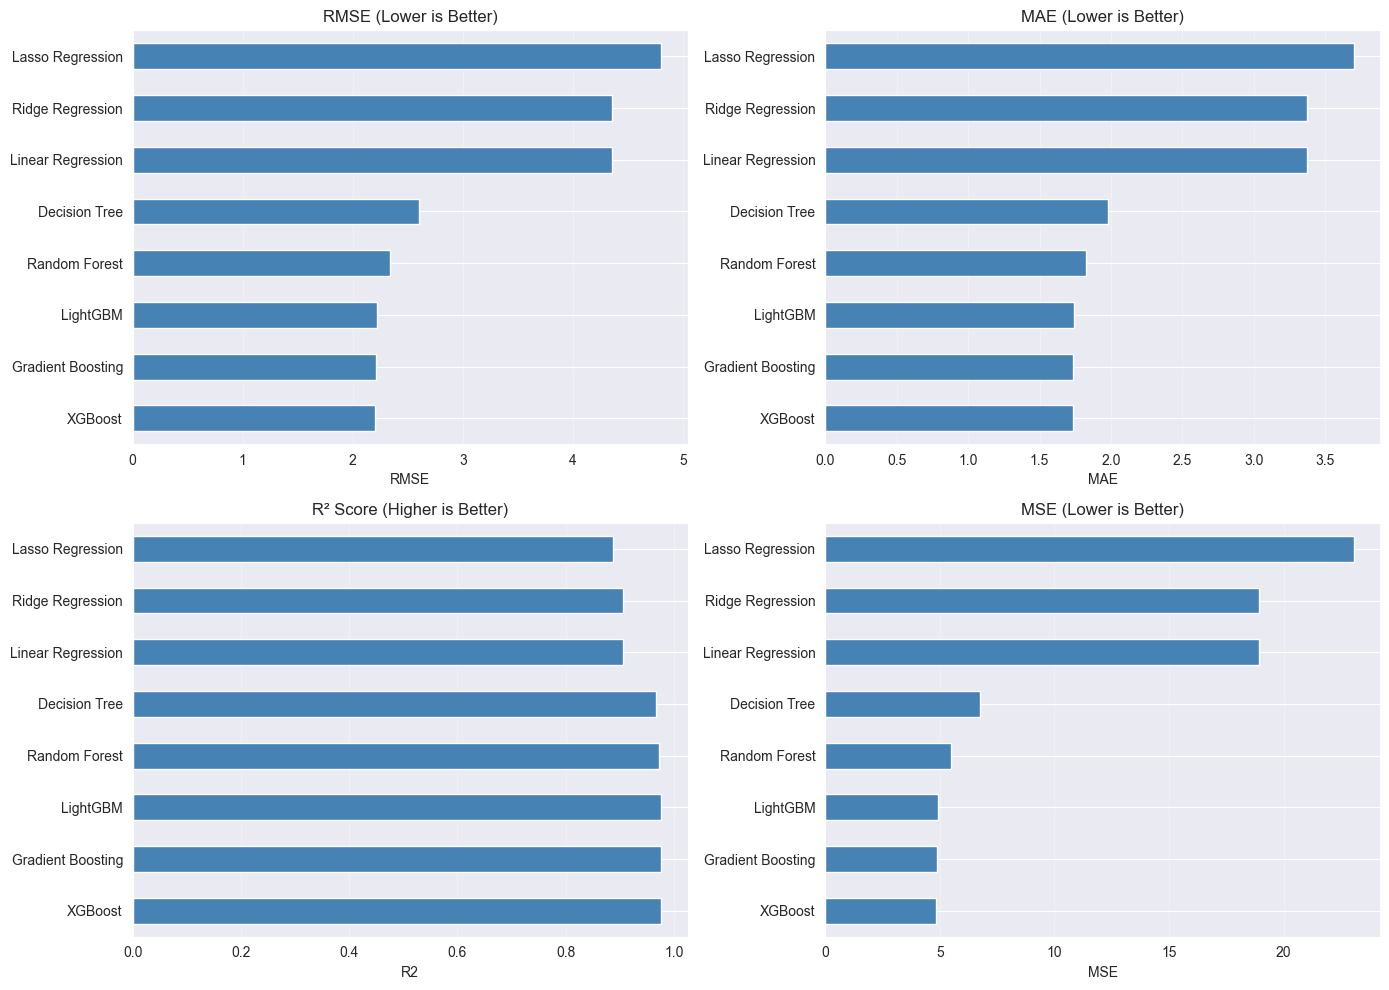

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['rmse', 'mae', 'r2', 'mse']
titles = ['RMSE (Lower is Better)', 'MAE (Lower is Better)',
          'R² Score (Higher is Better)', 'MSE (Lower is Better)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    results_df_sorted = results_df.sort_values(metric, ascending=(metric != 'r2'))
    results_df_sorted[metric].plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title(title)
    ax.set_xlabel(metric.upper())
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## BEST MODEL SELECTION

Best model based on validation RMSE: XGBoost
Validation RMSE: 2.1977

FINAL EVALUATION ON TEST SET

Model: XGBoost
Test RMSE: 2.1515
Test MAE:  1.6936
Test MSE:  4.6288
Test R²:   0.9770


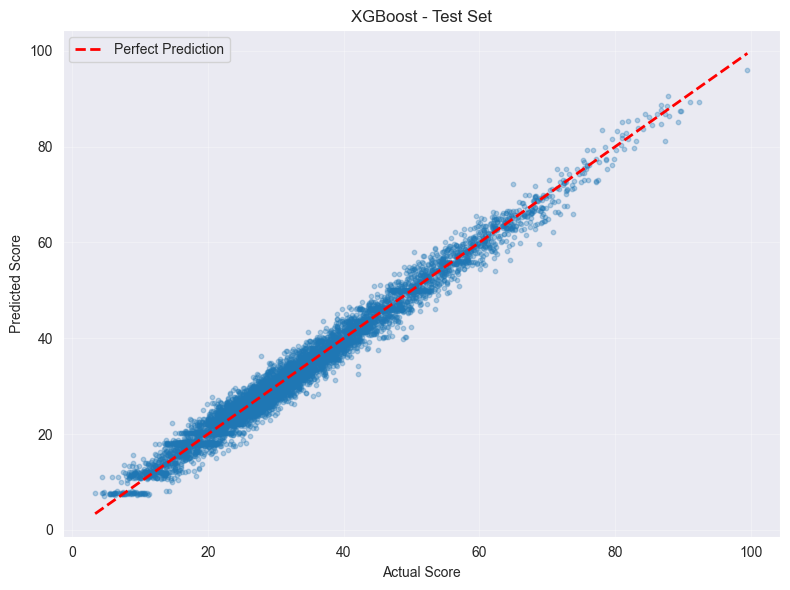

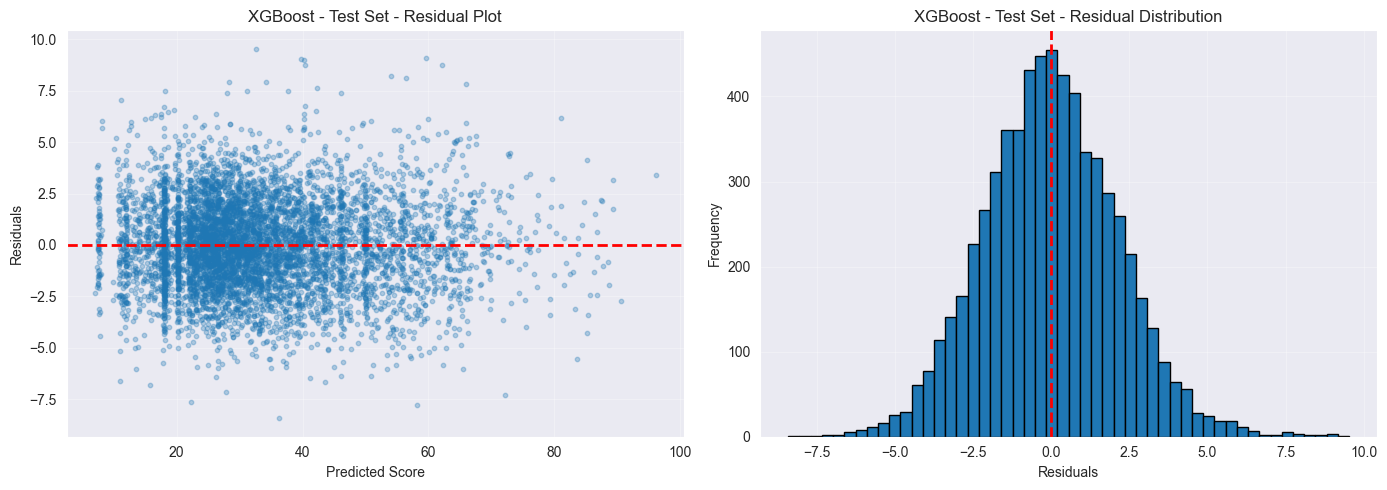

In [16]:
# Chọn theo RMSE
best_model_name = results_df['rmse'].idxmin()
print(f"Best model based on validation RMSE: {best_model_name}")
print(f"Validation RMSE: {results_df.loc[best_model_name, 'rmse']:.4f}")

model_map = {
    'Linear Regression': lr_model,
    'Ridge Regression': ridge_model,
    'Lasso Regression': lasso_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'XGBoost': xgb_model,
    'LightGBM': lgbm_model
}

best_model = model_map[best_model_name]

# Tính các chỉ số theo tập Set
print("\n" + "=" * 60)
print("FINAL EVALUATION ON TEST SET")
print("=" * 60)

y_test_pred = best_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nModel: {best_model_name}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE:  {test_mae:.4f}")
print(f"Test MSE:  {test_mse:.4f}")
print(f"Test R²:   {test_r2:.4f}")

plot_predictions(y_test, y_test_pred, f"{best_model_name} - Test Set")
plot_residuals(y_test, y_test_pred, f"{best_model_name} - Test Set")

## FEATURE IMPORTANCE ANALYSIS


Top 10 Most Important Features:
                feature  importance
  seniority_match_score    0.471421
         skill_coverage    0.143509
         experience_gap    0.113956
job_experience_required    0.056131
        education_match    0.047298
    skill_overlap_count    0.046787
          education_gap    0.028568
          skill_jaccard    0.022003
    cv_experience_years    0.019313
    job_education_level    0.016266


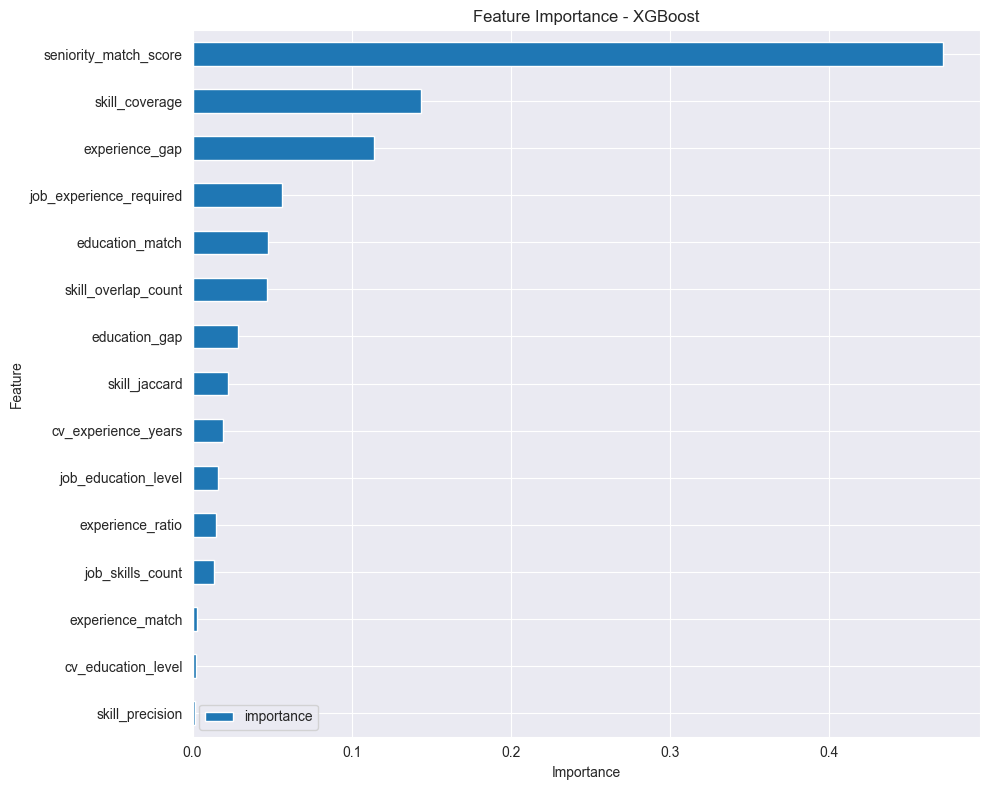

In [18]:
# Feature importance cho các tree-based models
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))

    plt.figure(figsize=(10, 8))
    feature_importance.head(15).plot.barh(x='feature', y='importance', ax=plt.gca())
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': best_model.coef_,
        'abs_coefficient': np.abs(best_model.coef_)
    }).sort_values('abs_coefficient', ascending=False)

    print("\nTop 10 Features by Coefficient Magnitude:")
    print(feature_importance.head(10).to_string(index=False))

    plt.figure(figsize=(10, 8))
    feature_importance.head(15).plot(
        x='feature', y='coefficient', kind='barh', legend=False
    )
    plt.title(f'Feature Coefficients - {best_model_name}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("\nFeature importance not available for this model type")